## Solving combinatorial optimization problems using QAOA

In [1]:
import sys
import time
import numpy as np
import pandas as pd
import pennylane as qml
import seaborn as sns
from dwave_qbsolv import QBSolv
from matplotlib import pyplot as plt
from pennylane import qaoa
import copy
import progressbar
import os
import os.path
from qiskit import IBMQ

import dimod.utilities

In [21]:
n = 5

np.set_printoptions(threshold=sys.maxsize)
QUBO_X = np.zeros((n, n))
np.set_printoptions(suppress=True)

In [3]:
qubo_d = {}
x1 = 0
while x1 < n:
    x2 = x1
    while x2 < n:
        qubo_d[(x1, x2)] = int(QUBO_X[x1][x2])
        x2 += 1
    x1 += 1
    
print(qubo_d)

{(0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (1, 1): 0, (1, 2): 0, (1, 3): 0, (1, 4): 0, (2, 2): 0, (2, 3): 0, (2, 4): 0, (3, 3): 0, (3, 4): 0, (4, 4): 0}


In [4]:
def make_symmetric(matrix):
    """ Takes a quadratic matrix and makes it symmetric """
    result = copy.deepcopy(matrix) # technically unnecessary
    for i in range(len(result)):
        for j in range(len(result[i])):
            if(i != j):
                if (result[i][j] != 0):
                    if (result[j][i] == 0):
                        result[j][i] = result[i][j] / 2
                        result[i][j] = result[j][i]
    return result
q_QUBO_X = make_symmetric(QUBO_X)

In [5]:
isingX = dimod.qubo_to_ising(qubo_d, 0)
print(isingX)
(linear, quadratic, _) = isingX
print("\n")
print(linear)
print("\n")
print(quadratic)

({0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}, {}, 0.0)


{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}


{}


In [6]:
n_qubits = n
wires = range(n_qubits)
depthX = 2

In [7]:
linear_coefficents = [linear[i] for i in range(n_qubits) if i in linear]
linear_gates = [qml.PauliZ(i) for i in range(n_qubits) if i in linear]
quadratic_coefficents = [quadratic[(i, j)] for i in range(n_qubits) for j in range(n_qubits) if (i, j) in quadratic]
quadratic_gates = [qml.PauliZ(i) @ qml.PauliZ(j) for i in range(n_qubits) for j in range(n_qubits) if
                       (i, j) in quadratic]

coefficents = linear_coefficents + quadratic_coefficents
gates = linear_gates + quadratic_gates

cost_h = qml.Hamiltonian(coefficents, gates)
print(cost_h)

  (0.0) [Z0]
+ (0.0) [Z1]
+ (0.0) [Z2]
+ (0.0) [Z3]
+ (0.0) [Z4]


In [8]:
mixer_h = qaoa.x_mixer(0)
for i in range(n_qubits - 1):
    mixer_h += qaoa.x_mixer(i + 1)
print(mixer_h)

  (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]


In [9]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [10]:
def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depthX, params[0], params[1])

In [11]:
token = '1c854f9916477c15b8ef30c1243313b67e739cfc30f10cd741d7ad787f102bca0f0e60f474acc939c10761884cc75eff19910dbc5fb2e045c1f56dc1b274d553'

In [12]:
dev = qml.device("qiskit.ibmq", wires=wires, ibmqx_token=token)


In [13]:
cost_function = qml.ExpvalCost(circuit, cost_h, dev, optimize=True)

In [14]:
optimizer = qml.AdamOptimizer() # qml.GradientDescentOptimizer() # qml.AdamOptimizer() # qml.AdagradOptimizer()

In [15]:
params = [[1.5346444645333537, 1.5932816845526026], [1.5451015974465807, 1.025692645307958]] #pre-optimized parameters

print("Start parameters: ", params)

Start parameters:  [[1.5346444645333537, 1.5932816845526026], [1.5451015974465807, 1.025692645307958]]


In [16]:
steps = 5

optimizerType = type(optimizer).__name__
path = os.getcwd()
print(path)
savestring = path + f"\{optimizerType}_{depthX}_{steps}_{params}"
print(savestring)

C:\Users\potap\PycharmProjects\quantum-walks-away\QW\QC Praktitum Kranzlmüller\12.10\Recap
C:\Users\potap\PycharmProjects\quantum-walks-away\QW\QC Praktitum Kranzlmüller\12.10\Recap\AdamOptimizer_2_5_[[1.5346444645333537, 1.5932816845526026], [1.5451015974465807, 1.025692645307958]]


In [17]:
for i in progressbar.progressbar(range(steps), redirect_stdout=True):
    params = optimizer.step(cost_function, params)
    print(' | New parameters:', params)
    print("\n", dev.num_executions)
    f = open(savestring + "paramsQuicksaveIBM.txt", 'a+')
    f.write("parameter quicksave stepnumber " + str(i) + ": " + str(params) + "\n\n")
    f.close()

print("\n")
print("Optimal parameters: ", params)

N/A% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

 | New parameters: [[1.5346444645333537, 1.5932816845526026], [1.5451015974465807, 1.025692645307958]]

 0
 | New parameters: [[1.5346444645333537, 1.5932816845526026], [1.5451015974465807, 1.025692645307958]]

 0
 | New parameters: [[1.5346444645333537, 1.5932816845526026], [1.5451015974465807, 1.025692645307958]]

 0
 | New parameters: [[1.5346444645333537, 1.5932816845526026], [1.5451015974465807, 1.025692645307958]]

 0
 | New parameters: [[1.5346444645333537, 1.5932816845526026], [1.5451015974465807, 1.025692645307958]]

 0


C:\Users\potap\AppData\Local\Programs\Python\Python38\lib\site-packages\autograd\tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00




Optimal parameters:  [[1.5346444645333537, 1.5932816845526026], [1.5451015974465807, 1.025692645307958]]


In [19]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

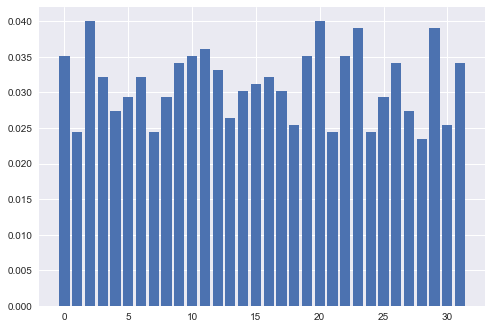

In [20]:
plt.style.use("seaborn")
plt.bar(range(2 ** len(wires)), probs)
plt.savefig(savestring + ".png")
plt.show()